/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


🗂️ Indexando imágenes...
📄 Archivos de prueba: 7558
🔍 Ejecutando inferencia...
7558/7558
📉 Generando matriz de confusión...


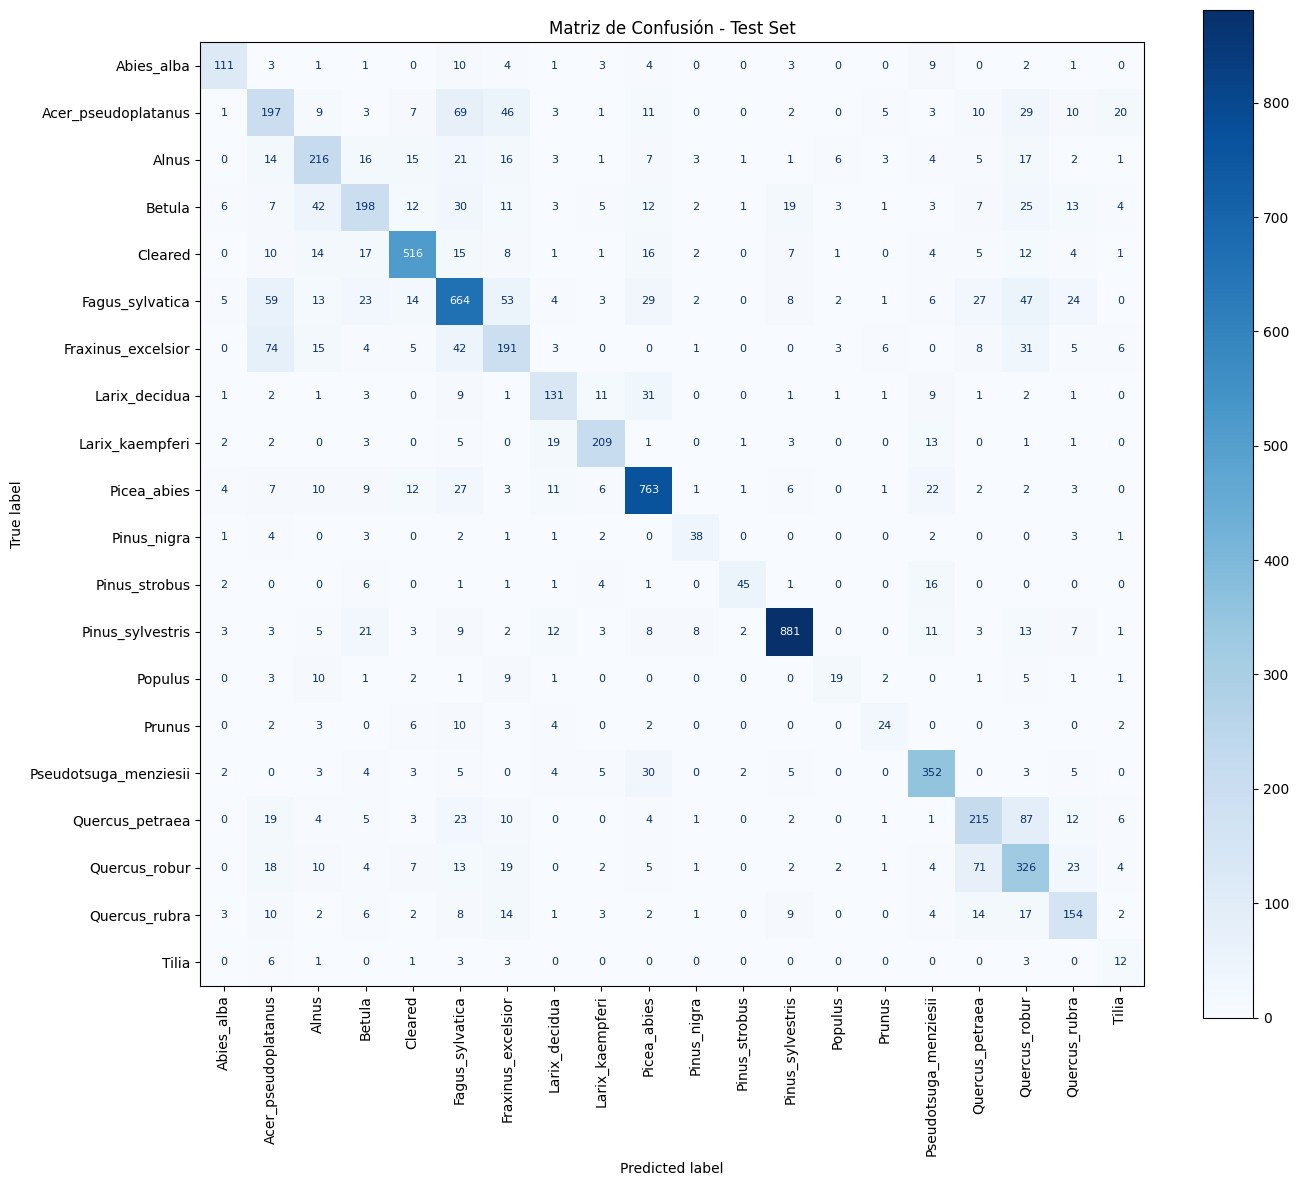


📋 Reporte de clasificación:
                       precision    recall  f1-score   support

           Abies_alba       0.79      0.73      0.76       153
  Acer_pseudoplatanus       0.45      0.46      0.45       426
                Alnus       0.60      0.61      0.61       352
               Betula       0.61      0.49      0.54       404
              Cleared       0.85      0.81      0.83       634
      Fagus_sylvatica       0.69      0.67      0.68       984
   Fraxinus_excelsior       0.48      0.48      0.48       394
        Larix_decidua       0.65      0.64      0.64       206
      Larix_kaempferi       0.81      0.80      0.81       260
          Picea_abies       0.82      0.86      0.84       890
          Pinus_nigra       0.63      0.66      0.64        58
        Pinus_strobus       0.85      0.58      0.69        78
     Pinus_sylvestris       0.93      0.89      0.91       995
              Populus       0.51      0.34      0.41        56
               Prunus    

In [1]:
import os
import json
import re
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# -----------------------------
# Configuración
# -----------------------------
MODEL_NAME = "resnet34"  # Cambiá por "resnet18" si usás ese modelo
MODEL_PATH = "/kaggle/input/treetecmodels/resnet34_transfer_10_epochs.pth"
TXT_PATH = "/kaggle/input/treetecmodels/test_files.txt"
IMG_DIR = "/kaggle/input/treesattfg/Images/Images"
SPECIES_JSON = "/kaggle/input/treesattfg/species_list.json"

# -----------------------------
# Cargar lista de especies
# -----------------------------
with open(SPECIES_JSON, 'r') as f:
    species_list = json.load(f)

species_to_idx = {s: i for i, s in enumerate(species_list)}

# -----------------------------
# Extraer especie desde nombre de archivo
# -----------------------------
def extract_species(filename):
    basename = os.path.basename(filename).replace(".tif", "")
    parts = basename.split('_')
    species_parts = []
    for part in parts:
        if part.isdigit():
            break
        species_parts.append(part)
    species = "_".join(species_parts)
    species = species.replace("_spec.", "").replace(".", "")
    return species

# -----------------------------
# Transformaciones
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -----------------------------
# Cargar modelo
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(species_list)
model = getattr(models, MODEL_NAME)(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# -----------------------------
# Crear índice de imágenes para acceso rápido
# -----------------------------
print("🗂️ Indexando imágenes...")
image_path_dict = {}
for root, _, files in os.walk(IMG_DIR):
    for file in files:
        if file.endswith(".tif"):
            image_path_dict[file] = os.path.join(root, file)

# -----------------------------
# Leer archivos de test
# -----------------------------
with open(TXT_PATH, 'r') as f:
    test_filenames = [line.strip() for line in f.readlines()]

print("📄 Archivos de prueba:", len(test_filenames))

# -----------------------------
# Inferencia
# -----------------------------
true_labels = []
pred_labels = []

print("🔍 Ejecutando inferencia...")
for i, filename in enumerate(test_filenames):
    print(f"{i+1}/{len(test_filenames)}", end="\r", flush=True)
    filepath = image_path_dict.get(filename)

    if filepath is None:
        print(f"⚠️ Archivo no encontrado: {filename}")
        continue

    true_species = extract_species(filename)
    if true_species not in species_to_idx:
        print(f"⚠️ Especie desconocida: {true_species} en archivo {filename}")
        continue

    true_idx = species_to_idx[true_species]

    image = Image.open(filepath).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        pred_idx = output.argmax(1).item()

    true_labels.append(true_idx)
    pred_labels.append(pred_idx)
    
# -----------------------------
# Matriz de confusión
# -----------------------------
print("\n📉 Generando matriz de confusión...")
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_list)
fig, ax = plt.subplots(figsize=(14, 12))  # Ajustá tamaño según cantidad de clases
disp.plot(cmap='Blues', xticks_rotation=90, ax=ax, values_format='d')

# Ajustar tamaño de fuente dentro del gráfico
for labels in ax.texts:
    labels.set_fontsize(8)

plt.title("Matriz de Confusión - Test Set")
plt.tight_layout()
plt.show()

# -----------------------------
# Reporte de clasificación
# -----------------------------
print("\n📋 Reporte de clasificación:")
print(classification_report(true_labels, pred_labels, target_names=species_list, zero_division=0))
